In [ ]:
#|default_exp train
#|export

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
import mne
import warnings
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader, ConcatDataset
import torch.optim as optim
from tqdm.notebook import tqdm
from IPython.display import clear_output, display
import umap

warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Define dataset paths
base_path = Path('/Users/yihein.chai/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Research/meg/CamCAN/cc700')
rest_path = base_path / 'rest'
noise_path = base_path / 'noise'

print("Dataset paths configured successfully!")

Dataset paths configured successfully!


In [2]:
def load_raw_meg_data(subject_id, base_path=rest_path):
    meg_file = base_path / f'sub-{subject_id}' / 'meg' / f'sub-{subject_id}_task-rest_meg.fif'
    
    if not meg_file.exists():
        raise FileNotFoundError(f"MEG file not found: {meg_file}")
    
    # Load MEG data using MNE
    raw = mne.io.read_raw_fif(meg_file, preload=True, verbose=False)
    
    return raw

In [ ]:
#|export

# Load real MEG data from CamCAN dataset
def load_meg_data(subject_id, base_path=rest_path):
    """
    Load and preprocess MEG data for a given subject.
    
    Parameters:
    -----------
    subject_id : str
        Subject ID (e.g., 'CC110033')
    base_path : Path
        Base path to the dataset
        
    Returns:
    --------
    data : ndarray
        Preprocessed MEG data of shape (n_channels, n_samples)
    """
    # Construct file path
    meg_file = base_path / f'sub-{subject_id}' / 'meg' / f'sub-{subject_id}_task-rest_meg.fif'
    
    if not meg_file.exists():
        raise FileNotFoundError(f"MEG file not found: {meg_file}")
    
    # Load MEG data using MNE
    raw = mne.io.read_raw_fif(meg_file, preload=True, verbose=False)
    
    # Keep only magnetometers for simplicity (102 channels)
    raw.pick_types(meg=True)
    
    # # Apply basic preprocessing
    # raw.filter(l_freq=1, h_freq=45, verbose=False)  # Band-pass filter
    # raw.notch_filter([50, 100], verbose=False)  # Remove line noise
    
    # Get data as numpy array
    data = raw.get_data()  # Shape: (n_channels, n_samples)
    
    return torch.from_numpy(data)


In [3]:
subject_id = 'CC110033'

meg_file = rest_path / f'sub-{subject_id}' / 'meg' / f'sub-{subject_id}_task-rest_meg.fif'

if not meg_file.exists():
    raise FileNotFoundError(f"MEG file not found: {meg_file}")

# Load MEG data using MNE
raw = mne.io.read_raw_fif(meg_file, preload=True, verbose=False)

raw.pick_types(meg=True)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<Raw | sub-CC110033_task-rest_meg.fif, 306 x 574000 (574.0 s), ~1.31 GiB, data loaded>

In [4]:
data = raw.get_data()

In [85]:
raw_cc110033 = load_raw_meg_data('CC110033')

In [ ]:
#|export

# Load data from multiple subjects
data_cc110033 = load_meg_data('CC110033')
data_cc110037 = load_meg_data('CC110037')
data_cc110045 = load_meg_data('CC110045')

datalist = [data_cc110033, data_cc110037, data_cc110045]

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


In [6]:
data.shape

torch.Size([918, 562000])

Text(0.5, 1.0, 'MEG Data (First 1000 Samples)')

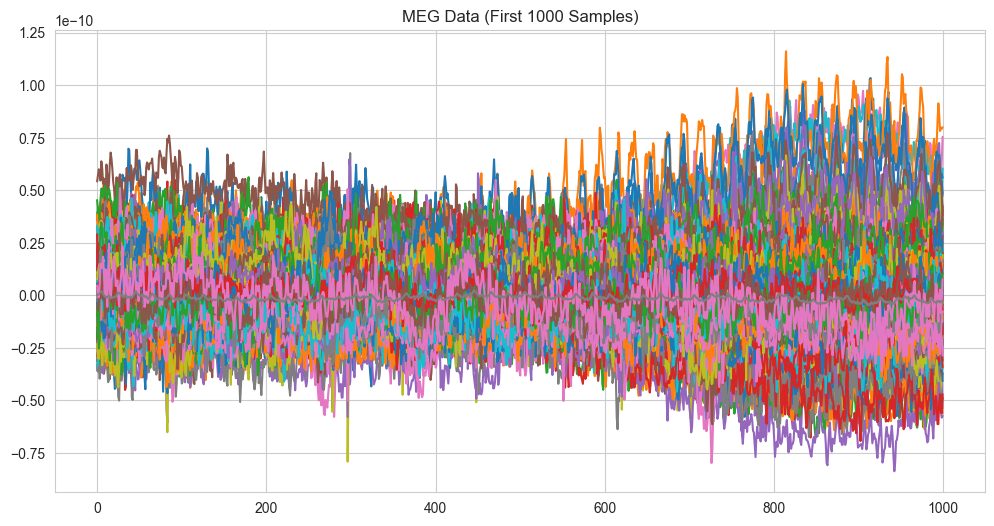

In [7]:
plt.plot(data.T[:1000])  # Plot first 1000 samples of all channels
plt.title('MEG Data (First 1000 Samples)')

In [ ]:
#|export

class NoiseInjection():
    def __init__(self):
        pass

    def __call__(self, timeseries):
        if isinstance(timeseries, np.ndarray):
            timeseries = torch.from_numpy(timeseries)

        std = timeseries.std()
        
        noise = torch.randn_like(timeseries) * std
        return timeseries + noise
    

class StdGaussianNoise():
    def __init__(self, *, std):
        self.std = std

    def __call__(self, timeseries):
        if isinstance(timeseries, np.ndarray):
            timeseries = torch.from_numpy(timeseries)
        return timeseries + (torch.randn_like(timeseries) * self.std)


class ZScore():
    def __init__(self):
        pass

    def __call__(self, timeseries: torch.Tensor):
        mean = timeseries.mean(dim=-1, keepdim=True) # (batch, 306, ..time..) avg across time
        std = timeseries.std(dim=-1, keepdim=True)
        return (timeseries - mean) / std

In [ ]:
#|export

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv1d(in_channels=306, out_channels=64, kernel_size=3, padding=1) # batch, 64, window_size
        self.relu = nn.ReLU()
        self.avg_pool = nn.AdaptiveAvgPool1d(output_size=1) # batch, 64

        self.fc = nn.Linear(64, 128) # batch, 128

    def forward(self, x: torch.Tensor):
        x = x.float()
        x = self.conv1(x)
        x = self.relu(x)
        x = self.avg_pool(x)

        x = x.squeeze(-1)

        x = self.fc(x)
        # x = self.relu(x) # do not collapse the embedding space
        
        return x

# class Projection(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.fc = nn.Linear(64, 128)
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         x = self.fc(x)
#         x = self.relu(x)

#         return x
    
# class Model()


In [ ]:
#|export

class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super().__init__()
        self.temperature = temperature

    def __call__(self, z1: torch.Tensor, z2: torch.Tensor):
        batch_size = z1.shape[0]

        z = torch.cat([z1, z2]) # 64 x 128 -> 128 x 128
        z = nn.functional.normalize(z)
        sim_matrix = (z @ z.T) / self.temperature

        # masking 
        sim_matrix = torch.masked_fill(sim_matrix, torch.eye(sim_matrix.shape[0]).bool(), -torch.inf)

        y = torch.Tensor([batch_size + i for i in range(batch_size)] + [i for i in range(batch_size)]).long()

        loss = nn.functional.cross_entropy(sim_matrix, y)

        return loss

In [ ]:
#|export

class MEG_Dataset(Dataset):
    def __init__(self, data, window_size=2000, transforms=None, stride=500):
        super().__init__()

        if transforms is None:
            raise TypeError("Transforms must be filled")
        
        self.window_size = window_size
        self.data = data
        self.transforms = transforms

        total_length = self.data.shape[-1]
        last_index = total_length - self.window_size
        self.stride = stride
        self.indices = [i for i in range(0, last_index, self.stride) if i <= last_index]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, index):
        start_index = self.indices[index]
        segment = self.data[:, start_index: start_index + self.window_size]
        view_1 = self.transforms(segment)
        view_2 = self.transforms(segment)

        return view_1, view_2

In [9]:
datalist[0].shape[-1]

574000

In [ ]:
#|export

aug_pipeline = transforms.Compose([ZScore(), StdGaussianNoise(std=0.1)])
datasets = [MEG_Dataset(data, window_size=2000, transforms=aug_pipeline) for data in datalist]
train_loader = DataLoader(ConcatDataset(datasets), batch_size=64, shuffle=True)

encoder = Encoder()
criterion = NTXentLoss(temperature=0.5)
optimiser = optim.Adam(encoder.parameters(), lr=1e-3)

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/53 [00:00<?, ?it/s]

4.817728042602539


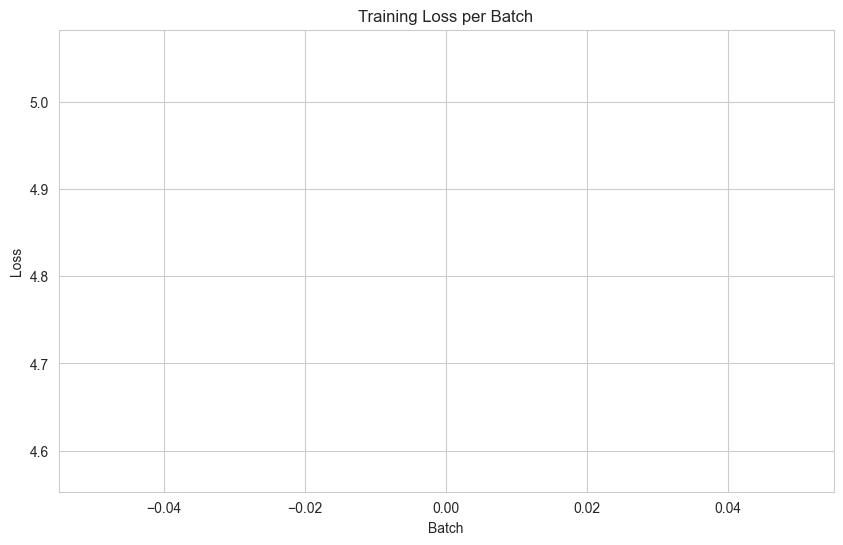

4.699025630950928
4.516554832458496
4.329390525817871
4.182377815246582
4.074909210205078
3.973252058029175
3.907078266143799
3.857436418533325
3.8269500732421875
3.7648069858551025
3.781019926071167
3.7975594997406006
3.7769811153411865
3.7746963500976562
3.735283374786377
3.762871742248535
3.744070291519165
3.729149580001831
3.588937282562256
3.665984630584717
3.7188880443573
3.6418612003326416
3.632931709289551
3.696354627609253
3.566547393798828
3.5421087741851807
3.549921751022339
3.5608699321746826
3.514944553375244
3.6001977920532227
3.519009828567505
3.686838388442993
3.5135600566864014
3.617903232574463
3.4794538021087646
3.6378698348999023
3.5605897903442383
3.569305896759033
3.4974629878997803
3.567532777786255
3.556398630142212
3.4924025535583496
3.497828722000122
3.4437127113342285
3.43501877784729
3.3694584369659424
3.4764113426208496
3.446120262145996
3.3915727138519287
3.46620512008667
3.4580931663513184
3.2824127674102783
Epoch 1/50, Loss: 3.7037


Epoch 2/50:   0%|          | 0/53 [00:00<?, ?it/s]

3.325575590133667
3.3989627361297607
3.500204563140869
3.484079599380493
3.440566301345825
3.499298334121704
3.4842798709869385
3.2985446453094482
3.397858142852783
3.379612445831299
3.4983456134796143
3.427002191543579
3.364142656326294
3.348720073699951
3.494232416152954
3.370870351791382
3.426584482192993
3.486053228378296
3.317814826965332
3.31176495552063
3.404987096786499
3.42335844039917
3.400967836380005
3.3619658946990967
3.3445465564727783
3.389397144317627
3.2885773181915283
3.2506637573242188
3.308607816696167
3.2410027980804443
3.2263970375061035
3.2521867752075195
3.2772843837738037
3.219275712966919
3.250046730041504
3.281193971633911
3.3428022861480713
3.255321979522705
3.2692928314208984
3.2508580684661865
3.2763068675994873
3.2862653732299805
3.2884409427642822
3.289790630340576
3.2750017642974854
3.3174827098846436
3.285259962081909
3.331737518310547
3.3079729080200195
3.2749674320220947
3.2769904136657715
3.2418038845062256
3.1785085201263428
Epoch 2/50, Loss: 3.338

Epoch 3/50:   0%|          | 0/53 [00:00<?, ?it/s]

3.3249080181121826
3.2370705604553223
3.2604503631591797
3.252345085144043
3.315782308578491
3.344896078109741
3.2521698474884033
3.2443783283233643
3.2255654335021973
3.2094995975494385
3.2727251052856445
3.215362787246704
3.2528128623962402
3.2493815422058105
3.2826919555664062
3.2436599731445312
3.259744882583618
3.2526776790618896
3.216352939605713
3.2439045906066895
3.228999376296997
3.2452800273895264
3.1807167530059814
3.198007106781006
3.200531482696533
3.2474231719970703
3.1675047874450684
3.1582212448120117
3.244198799133301
3.2587852478027344
3.204369068145752
3.234492540359497
3.2625832557678223
3.2039899826049805
3.187530040740967
3.1985578536987305
3.206724166870117
3.31070876121521
3.2083895206451416
3.1938371658325195
3.2784650325775146
3.2142045497894287
3.232283592224121
3.2305808067321777
3.194587469100952
3.2016446590423584
3.219696283340454
3.1923913955688477
3.2461390495300293
3.2085163593292236
3.191296339035034
3.224158763885498
3.023972272872925
Epoch 3/50, Los

Epoch 4/50:   0%|          | 0/53 [00:00<?, ?it/s]

3.1867077350616455
3.1629083156585693
3.2092907428741455
3.2017765045166016
3.178264617919922
3.1678848266601562
3.1965441703796387
3.1867947578430176
3.1553421020507812
3.2231600284576416
3.158587694168091
3.171088457107544
3.1733696460723877
3.180048704147339
3.14986515045166
3.2274422645568848
3.1950840950012207
3.169085741043091
3.1533055305480957
3.1587729454040527
3.13930344581604
3.2383739948272705
3.172834634780884
3.1688129901885986
3.1590137481689453
3.2087762355804443
3.171095132827759
3.1387507915496826
3.190394639968872
3.1646780967712402
3.156670331954956
3.1412086486816406
3.162855863571167
3.1283154487609863
3.1541428565979004
3.1508452892303467
3.126391649246216
3.195173501968384
3.148799180984497
3.1172993183135986
3.1520349979400635
3.1874473094940186
3.1711087226867676
3.1579809188842773
3.1321330070495605
3.1605896949768066
3.152526617050171
3.1826109886169434
3.1785130500793457
3.166788101196289
3.162475347518921
3.1621665954589844
3.0460116863250732
Epoch 4/50, L

Epoch 5/50:   0%|          | 0/53 [00:00<?, ?it/s]

3.1597609519958496
3.1686270236968994
3.171499490737915
3.176738977432251
3.200847625732422
3.153085470199585
3.182941198348999
3.1428399085998535
3.14615535736084
3.2014336585998535
3.148104667663574
3.1430628299713135
3.173184633255005
3.189640760421753
3.15682053565979
3.1584324836730957
3.1492156982421875
3.1595659255981445
3.1851866245269775
3.1141624450683594
3.151486396789551
3.174837350845337
3.1940317153930664
3.1727945804595947
3.1708860397338867
3.174076557159424
3.2405917644500732
3.143141508102417
3.23252272605896
3.224356174468994
3.179400682449341
3.2340211868286133
3.246049642562866
3.190744400024414
3.1981000900268555
3.1529700756073
3.186044454574585
3.2036056518554688
3.270266056060791
3.207615613937378
3.1848304271698
3.1522812843322754
3.1372506618499756
3.1882877349853516
3.215867757797241
3.200505256652832
3.1265742778778076
3.158609628677368
3.146629571914673
3.1468749046325684
3.1804866790771484
3.1344003677368164
3.019763708114624
Epoch 5/50, Loss: 3.1740


Epoch 6/50:   0%|          | 0/53 [00:00<?, ?it/s]

3.138166666030884
3.1350958347320557
3.151085138320923
3.1439056396484375
3.137409210205078
3.123356580734253
3.125810384750366
3.17034649848938
3.107888698577881
3.168165445327759
3.172010898590088
3.152524471282959
3.1292402744293213
3.119628667831421
3.1719138622283936
3.105872392654419
3.146129846572876
3.1148664951324463
3.1239993572235107
3.0977962017059326
3.1233341693878174
3.1157310009002686
3.1368865966796875
3.0904221534729004
3.12984561920166
3.0961694717407227
3.088000774383545
3.112720489501953
3.146719217300415
3.165879726409912
3.111011266708374
3.1499242782592773
3.140566825866699
3.128912925720215
3.1316065788269043
3.1635074615478516
3.1455142498016357
3.10302996635437
3.100071430206299
3.1482272148132324
3.1469554901123047
3.1031620502471924
3.1080148220062256
3.1142919063568115
3.125338315963745
3.1516919136047363
3.097611427307129
3.10310697555542
3.1513218879699707
3.1970272064208984
3.1277458667755127
3.1412394046783447
2.997946262359619
Epoch 6/50, Loss: 3.1288

Epoch 7/50:   0%|          | 0/53 [00:00<?, ?it/s]

3.141587972640991
3.1304147243499756
3.1410725116729736
3.1333885192871094
3.1132566928863525
3.1227593421936035
3.146632194519043
3.1802849769592285
3.1261465549468994
3.1285221576690674
3.1382486820220947
3.14992356300354
3.1391754150390625
3.113807439804077
3.1022109985351562
3.1144559383392334
3.167254686355591
3.108024835586548
3.111665964126587
3.1296370029449463
3.1381571292877197
3.106870174407959
3.103149652481079
3.138129472732544
3.136935234069824
3.1136906147003174
3.12226939201355
3.118511199951172
3.1260931491851807
3.100964307785034
3.096033811569214
3.1480772495269775
3.10992693901062
3.1458311080932617
3.143944501876831
3.1400957107543945
3.1961934566497803
3.1079230308532715
3.0790321826934814
3.1478655338287354
3.1262643337249756
3.119152545928955
3.068941831588745
3.1081180572509766
3.1369636058807373
3.1217989921569824
3.1464219093322754
3.1197049617767334
3.0916566848754883
3.135093927383423
3.157252311706543
3.1203255653381348
2.9785118103027344
Epoch 7/50, Loss:

Epoch 8/50:   0%|          | 0/53 [00:00<?, ?it/s]

3.132603645324707
3.103829860687256
3.0944888591766357
3.1285009384155273
3.108854055404663
3.0775794982910156
3.0934133529663086
3.0985445976257324
3.1128320693969727
3.084057092666626
3.100147008895874
3.0747005939483643
3.0775179862976074
3.1096460819244385
3.097632884979248
3.100989580154419
3.1038670539855957
3.123581647872925
3.0840811729431152
3.108187198638916
3.110260486602783
3.105821371078491
3.108097791671753
3.144541025161743
3.087934732437134
3.103914737701416
3.0747530460357666
3.120076894760132
3.075361967086792
3.1120104789733887
3.0622875690460205
3.0756406784057617
3.0809123516082764
3.1109426021575928
3.143993854522705
3.094370126724243
3.084315061569214
3.098632574081421
3.103445291519165
3.110478162765503
3.1323301792144775
3.1136090755462646
3.118133544921875
3.1131932735443115
3.130618095397949
3.0786261558532715
3.113213300704956
3.1180245876312256
3.1479809284210205
3.0575318336486816
3.0800583362579346
3.1052749156951904
2.9916136264801025
Epoch 8/50, Loss: 3

Epoch 9/50:   0%|          | 0/53 [00:00<?, ?it/s]

3.060490369796753
3.074409246444702
3.0923755168914795
3.143904685974121
3.0989773273468018
3.1156842708587646
3.1082890033721924
3.1869618892669678
3.154865264892578
3.1040661334991455
3.1560187339782715
3.103848695755005
3.0974977016448975
3.110433340072632
3.129075765609741
3.128941774368286
3.0819289684295654
3.089648962020874
3.1311404705047607
3.1401009559631348
3.1333000659942627
3.1024234294891357
3.0936291217803955
3.0636775493621826
3.091386556625366
3.1295764446258545
3.0840959548950195
3.087552309036255
3.075974702835083
3.1165268421173096
3.0993685722351074
3.078805923461914
3.0648510456085205
3.0793445110321045
3.0824575424194336
3.075075387954712
3.106419086456299
3.0926871299743652
3.066312551498413
3.0881083011627197
3.0753495693206787
3.0933661460876465
3.107044219970703
3.072531223297119
3.0890188217163086
3.0646698474884033
3.06815505027771
3.0880565643310547
3.074479341506958
3.0895771980285645
3.088669776916504
3.0821144580841064
2.9376132488250732
Epoch 9/50, Los

Epoch 10/50:   0%|          | 0/53 [00:00<?, ?it/s]

3.093946933746338
3.0742380619049072
3.0961720943450928
3.079890251159668
3.0875797271728516
3.0949764251708984
3.09713077545166
3.08092999458313
3.088850975036621
3.109581708908081
3.11916446685791
3.1103503704071045
3.097059726715088
3.0954625606536865
3.063263177871704
3.0736546516418457
3.1075875759124756
3.0993266105651855
3.0767977237701416
3.088733434677124
3.0839550495147705
3.0936882495880127
3.0757551193237305
3.082503080368042
3.0814437866210938
3.0663564205169678
3.1021742820739746
3.0801584720611572
3.081498622894287
3.06282377243042
3.0845274925231934
3.0568881034851074
3.0606889724731445
3.092802047729492
3.104018211364746
3.075664758682251
3.081066370010376
3.0789847373962402
3.1179234981536865
3.084374189376831
3.1314878463745117
3.1007187366485596
3.0862958431243896
3.0905144214630127
3.0745370388031006
3.081744432449341
3.050025701522827
3.1280853748321533
3.1214869022369385
3.088026285171509
3.1032841205596924
3.082796096801758
2.9936137199401855
Epoch 10/50, Loss: 

Epoch 11/50:   0%|          | 0/53 [00:00<?, ?it/s]

3.0737216472625732
3.09800124168396
3.093022346496582
3.044426918029785
3.0853118896484375
3.104454517364502
3.099813461303711
3.0790250301361084
3.0736570358276367
3.0650930404663086
3.0832149982452393
3.070558786392212
3.078726291656494
3.1037685871124268
3.089600086212158
3.0689780712127686
3.1020827293395996
3.060350179672241
3.074270725250244
3.0951151847839355
3.1120004653930664
3.0833051204681396
3.0819578170776367
3.108154058456421
3.0743913650512695
3.0613350868225098
3.108431339263916
3.120755434036255
3.084407329559326
3.0876057147979736
3.125089406967163
3.0552070140838623
3.077676773071289
3.0636470317840576
3.0939204692840576
3.088150978088379
3.0840933322906494
3.072258234024048
3.0875370502471924
3.0996527671813965
3.101282835006714
3.0494561195373535
3.0684309005737305
3.0795626640319824
3.0680747032165527
3.086296558380127
3.099064350128174
3.1216511726379395
3.0995771884918213
3.109585762023926
3.0856645107269287
3.0835659503936768
3.0206730365753174
Epoch 11/50, Los

Epoch 12/50:   0%|          | 0/53 [00:00<?, ?it/s]

3.1164817810058594
3.10305118560791
3.0843334197998047
3.083631753921509
3.107556104660034
3.0693531036376953
3.0949459075927734
3.097599744796753
3.069676399230957
3.077305555343628
3.1044301986694336
3.0842785835266113
3.091362476348877
3.0888116359710693
3.0558972358703613
3.08975887298584
3.0601391792297363
3.0672714710235596
3.089406967163086
3.0826730728149414
3.1137502193450928
3.1057538986206055
3.067763090133667
3.090449571609497
3.075615406036377
3.098054885864258
3.0633606910705566
3.066026210784912
3.061583995819092
3.042996883392334
3.0785248279571533
3.0866410732269287
3.0550081729888916
3.063899517059326
3.0615944862365723
3.0852551460266113
3.0732290744781494
3.080349922180176
3.0988335609436035
3.0905959606170654
3.085341453552246
3.082763910293579
3.1129202842712402
3.076282262802124
3.0902013778686523
3.0659029483795166
3.1040852069854736
3.0484795570373535
3.089775323867798
3.087538719177246
3.0735654830932617
3.0703353881835938
2.9168319702148438
Epoch 12/50, Loss:

Epoch 13/50:   0%|          | 0/53 [00:00<?, ?it/s]

3.134999990463257
3.112443208694458
3.0926783084869385
3.085113763809204
3.070542097091675
3.1000921726226807
3.130197525024414
3.0743699073791504
3.08035945892334
3.0714101791381836
3.0608108043670654
3.0733377933502197
3.090851306915283
3.079089641571045
3.0481982231140137
3.09142804145813
3.093543291091919
3.108480215072632
3.096461534500122
3.0770201683044434
3.1129987239837646
3.073284149169922
3.091928720474243
3.0815627574920654
3.0690512657165527
3.070660352706909
3.0832536220550537
3.049675226211548
3.067460536956787
3.135662078857422
3.0459353923797607
3.1058902740478516
3.089193820953369
3.085024118423462
3.066417694091797
3.0838253498077393
3.0587053298950195
3.0707015991210938
3.0551540851593018
3.056262493133545
3.0639264583587646
3.0613818168640137
3.070134162902832
3.0671863555908203
3.0711452960968018
3.051654815673828
3.102689504623413
3.082052230834961
3.0780045986175537
3.0922110080718994
3.0577921867370605
3.0522308349609375
2.9682629108428955
Epoch 13/50, Loss: 3.

Epoch 14/50:   0%|          | 0/53 [00:00<?, ?it/s]

3.0475170612335205
3.058849811553955
3.12410569190979
3.0659050941467285
3.0693047046661377
3.077816963195801
3.096296787261963
3.0859603881835938
3.124539852142334
3.046067953109741
3.0528101921081543
3.0758233070373535
3.074252128601074
3.123222589492798
3.0493600368499756
3.089016914367676
3.0993213653564453
3.0448267459869385
3.0757620334625244
3.0796432495117188
3.123387098312378
3.0753965377807617
3.0557732582092285
3.13112735748291
3.05715274810791
3.138775587081909
3.093111038208008
3.043456792831421
3.088268280029297
3.054155111312866
3.078428268432617
3.039017915725708
3.0628902912139893
3.0700180530548096
3.0775201320648193
3.0935451984405518
3.08921480178833
3.1162209510803223
3.1072354316711426
3.0705959796905518
3.074587106704712
3.0424716472625732
3.085693120956421
3.067086935043335
3.109654664993286
3.074801445007324
3.101576805114746
3.0360896587371826
3.042160749435425
3.040888547897339
3.1035313606262207
3.0774853229522705
2.943265914916992
Epoch 14/50, Loss: 3.0759


Epoch 15/50:   0%|          | 0/53 [00:00<?, ?it/s]

3.0424587726593018
3.1291487216949463
3.078205108642578
3.0886995792388916
3.0643372535705566
3.069032669067383
3.0517566204071045
3.0601577758789062
3.052269458770752
3.0521938800811768
3.0944714546203613
3.0993967056274414
3.085691452026367
3.086578130722046
3.0772511959075928
3.0358173847198486
3.0555639266967773
3.0675034523010254
3.0666563510894775
3.098254680633545
3.076155424118042
3.058631181716919
3.0714924335479736
3.1229918003082275
3.0713510513305664
3.050727605819702
3.0857393741607666
3.072213649749756
3.1060092449188232
3.0774714946746826
3.078986883163452
3.0961124897003174
3.0771872997283936
3.0496952533721924
3.1323728561401367
3.043203115463257
3.0800259113311768
3.104663610458374
3.064594268798828
3.0713329315185547
3.0375659465789795
3.0646324157714844
3.0521152019500732
3.0609326362609863
3.0363869667053223
3.0443270206451416
3.0604848861694336
3.0282089710235596
3.0594513416290283
3.036525249481201
3.055065870285034
3.055187702178955
2.9144206047058105
Epoch 15/5

Epoch 16/50:   0%|          | 0/53 [00:00<?, ?it/s]

3.0859553813934326
3.0818305015563965
3.068466901779175
3.065166711807251
3.058964490890503
3.057070255279541
3.0439934730529785
3.0756418704986572
3.085355281829834
3.0497708320617676
3.0572922229766846
3.073068380355835
3.0441324710845947
3.0675837993621826
3.072885751724243
3.048442840576172
3.1225426197052
3.120504856109619
3.057865619659424
3.0806467533111572
3.069169282913208
3.0713441371917725
3.0742990970611572
3.0944666862487793
3.0558838844299316
3.079149007797241
3.096289873123169
3.0517690181732178
3.0680925846099854
3.041468381881714
3.07004976272583
3.089871644973755
3.076720952987671
3.044898271560669
3.097593307495117
3.080428123474121
3.0477988719940186
3.058032274246216
3.027050495147705
3.039440870285034
3.0414371490478516
3.060692071914673
3.0767099857330322
3.0740275382995605
3.0657906532287598
3.0339412689208984
3.063530445098877
3.0857479572296143
3.049217939376831
3.046062469482422
3.079641103744507
3.101986885070801
2.9491384029388428
Epoch 16/50, Loss: 3.0656


Epoch 17/50:   0%|          | 0/53 [00:00<?, ?it/s]

3.082362174987793
3.0661299228668213
3.063148021697998
3.07723331451416
3.0388410091400146
3.0676281452178955
3.0395524501800537
3.0822319984436035
3.1093685626983643
3.0430920124053955
3.0836546421051025
3.063871145248413
3.054124355316162
3.121847629547119
3.0297698974609375
3.018000602722168
3.066227912902832
3.051694869995117
3.101633310317993
3.0896713733673096
3.052639961242676
3.0696768760681152
3.0401580333709717
3.045606851577759


KeyboardInterrupt: 

In [ ]:
#|export

encoder.train()

num_epochs = 50

fig, ax = plt.subplots(figsize=(10, 6))
display_handle = display(fig, display_id=True)
losses = []
batch_nums = []

for epoch in tqdm(range(num_epochs), desc='Epochs'):
    epoch_loss = 0.0
    for batch_idx, (x1, x2) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)):
        z1 = encoder(x1)
        z2 = encoder(x2)

        loss = criterion(z1, z2)
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        epoch_loss += loss.item()

        # Track metrics for live plot
        losses.append(loss.item())
        batch_nums.append(epoch * len(train_loader) + batch_idx)

        print(losses[-1])

        if batch_idx % 5 == 0 or batch_idx == len(train_loader) - 1:
            ax.clear()
            ax.plot(batch_nums, losses)
            ax.set_xlabel('Batch')
            ax.set_ylabel('Loss')
            ax.set_title('Training Loss per Batch')
            ax.grid(True)
            display_handle.update(fig)

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}')

display_handle.update(fig)

In [ ]:
#|export

torch.save({"model_state_dict": encoder.state_dict(), "optimizer_state_dict": optimiser.state_dict()}, 'checkpoint.pth')

In [ ]:
#|export

encoder = Encoder()
encoder.load_state_dict(torch.load("checkpoint.pth", map_location=torch.device('cpu'))['model_state_dict'])

<All keys matched successfully>

In [ ]:
#|export

encoder.eval()

all_embeddings = {}

with torch.no_grad():
    for i, data in enumerate(datalist):
        individual_embeddings = []
        infer_dataloader = DataLoader(MEG_Dataset(data, window_size=2000, transforms=transforms.Compose([ZScore()])), batch_size=256, shuffle=False)

        for x1, x2 in infer_dataloader:
            z1 = encoder(x1)
            individual_embeddings.append(z1)
        
        all_embeddings[i] = torch.cat(individual_embeddings, dim=0)




In [ ]:
#|export

all_embeddings_list = []
age_labels_list = []
sex_labels_list = []
individual_details_mapping = {
    0: {"age": 24.7, "sex": 1},
    1: {"age": 18.9, "sex": 1},
    2: {"age": 24.6, "sex": 0}
}

for idx, emd in all_embeddings.items():
    age = individual_details_mapping[idx]["age"]
    sex = individual_details_mapping[idx]["sex"]

    num_windows = emd.shape[0]
    all_embeddings_list.append(emd)

    age_labels = np.full(num_windows, age)
    age_labels_list.append(age_labels)

    sex_labels = np.full(num_windows, sex)
    sex_labels_list.append(sex_labels)



dim_reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, n_components=2, random_state=42)
embedding_2d = dim_reducer.fit_transform(torch.cat(all_embeddings_list).numpy())

In [90]:
all_embeddings[0].shape

torch.Size([1144, 128])

In [21]:
embedding_2d.shape

(3384, 2)

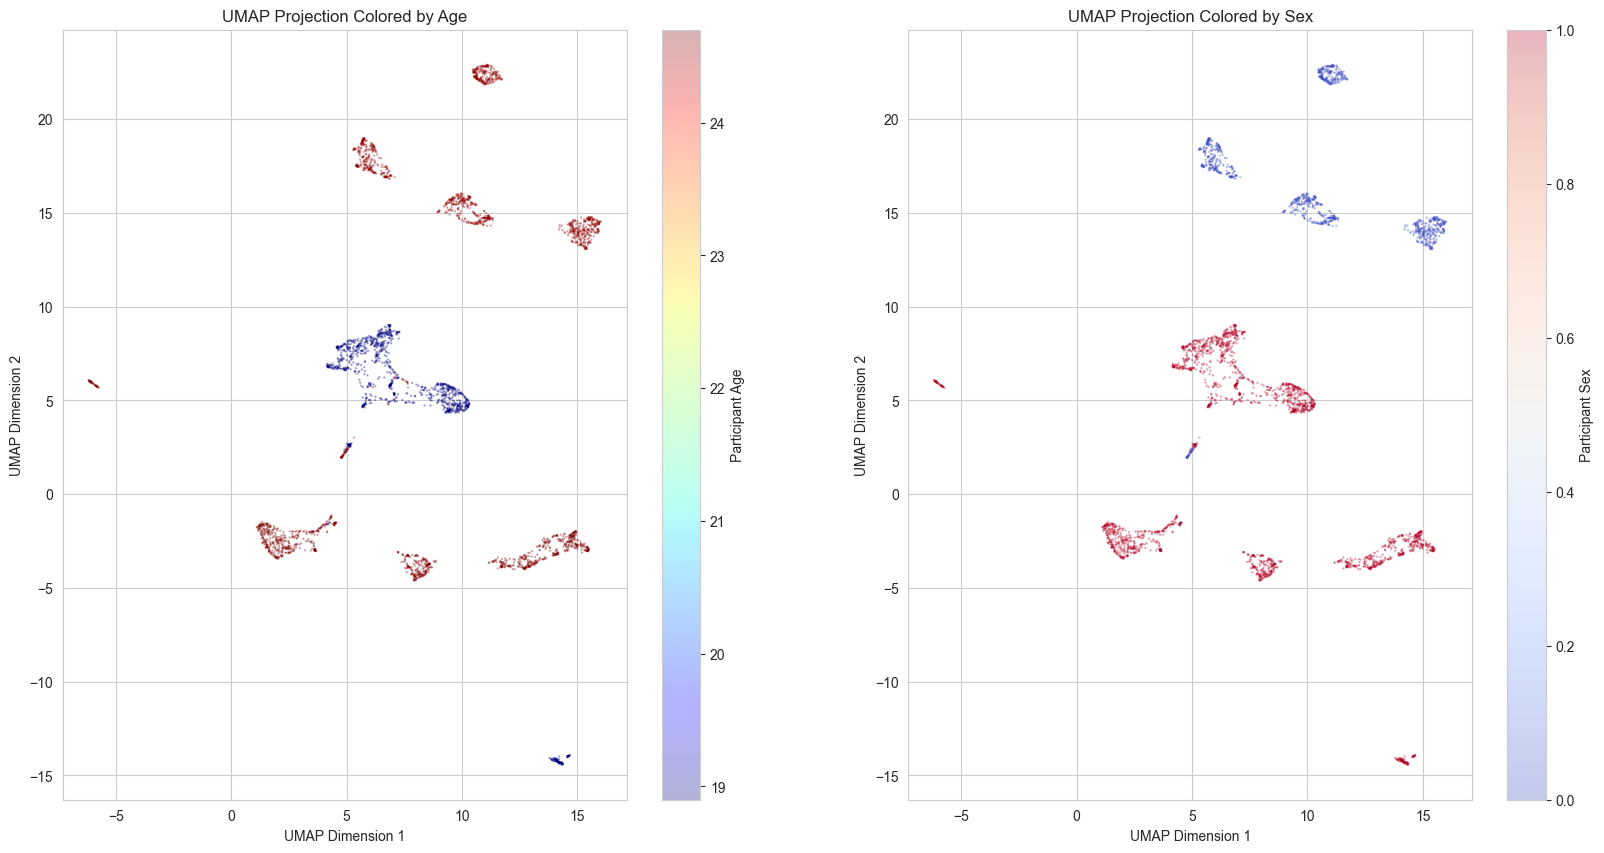

In [ ]:
#|export

age_labels_numpy = np.concatenate(age_labels_list, axis=0)
sex_labels_numpy = np.concatenate(sex_labels_list, axis=0)

# --- Create a 1x2 figure ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# --- Plot 1: Colored by AGE ---
plot1 = ax1.scatter(
    embedding_2d[:, 0], 
    embedding_2d[:, 1],
    c=age_labels_numpy,    # Color by age
    cmap='jet',            # Continuous colormap
    s=0.5,
    alpha=0.3
)
ax1.set_title('UMAP Projection Colored by Age')
ax1.set_xlabel('UMAP Dimension 1')
ax1.set_ylabel('UMAP Dimension 2')
fig.colorbar(plot1, ax=ax1, label='Participant Age')

# --- Plot 2: Colored by SEX ---
# (Assuming sex=0 and sex=1)
plot2 = ax2.scatter(
    embedding_2d[:, 0], 
    embedding_2d[:, 1],
    c=sex_labels_numpy,    # Color by sex
    cmap='coolwarm',       # Categorical colormap
    s=0.5,
    alpha=0.3
)
ax2.set_title('UMAP Projection Colored by Sex')
ax2.set_xlabel('UMAP Dimension 1')
ax2.set_ylabel('UMAP Dimension 2')
fig.colorbar(plot2, ax=ax2, label='Participant Sex')

plt.show()

In [109]:
transform = transforms.Compose([ZScore(), StdGaussianNoise(std=0.5)])
norm_transform = transforms.Compose([ZScore()])

In [ ]:
raw_cc110033.pa

<Raw | sub-CC110033_task-rest_meg.fif, 339 x 574000 (574.0 s), ~1.46 GiB, data loaded>

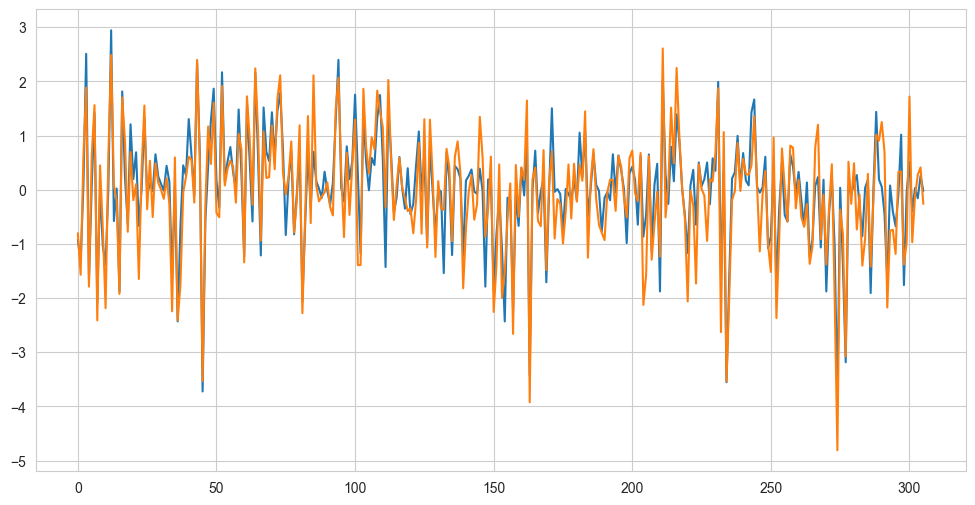

In [110]:
plt.plot(norm_transform(data[:1000,0]))
plt.plot(transform(data[:1000,0]))

In [3]:
from nbdev.export import nb_export 

nb_export('understand.ipynb', '.')